In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import os
from gempy.bayesian.fields import compute_prob, calculate_ie_masked
from skimage.transform import resize
import pyvista as pv
import matplotlib.pyplot as plt
import  matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Methods figures

In [15]:
data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'
path_to_data = data_path + "/data/input_data/jan_models/"

geo_data = gp.create_data('fault', extent=[0, 1000, 0, 1000, 0, 1000], resolution=[80,80,80],
                          path_o=path_to_data + "model5_orientations.csv",
                          path_i=path_to_data + "model5_surface_points.csv")
gp.map_stack_to_surfaces(geo_data, {"Fault_Series": 'fault',
                                    "Strat_Series": ('rock2', 'rock1')})
geo_data.set_is_fault(['Fault_Series'])

geo_data.surfaces.colors.change_colors({'rock1': '#a1d99b',
                                        'rock2' : '#3182bd',
                                        'basement' : '#d9d9d9'})
interp_data = gp.set_interpolator(geo_data, theano_optimizer='fast_compile')
sol = gp.compute_model(geo_data)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                        values
range             1732.050808
$C_o$            71428.571429
drift equations     [3, 3, 3]


C:\ProgramData\Anaconda3\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


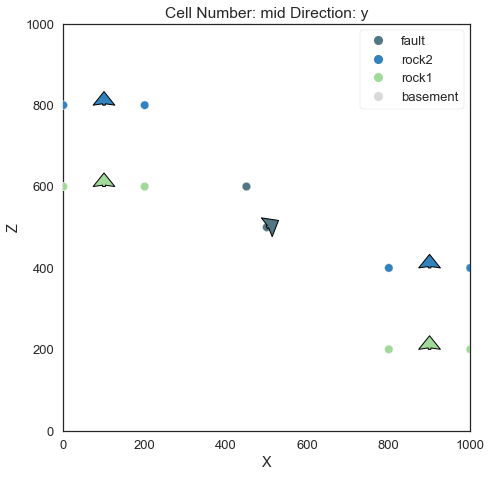

In [24]:
gp.plot_2d(geo_data, direction='y', show_results = False)
plt.savefig('data.svg')

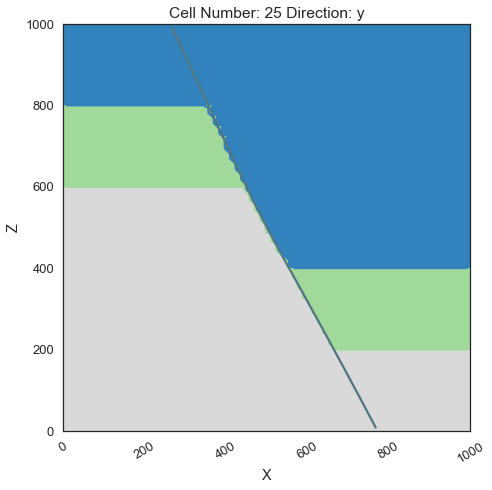

In [25]:
gp.plot_2d(geo_data, cell_number=25,
           direction='y', show_data=False, show_all_data=True)
plt.savefig('model.svg')

C:\ProgramData\Anaconda3\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


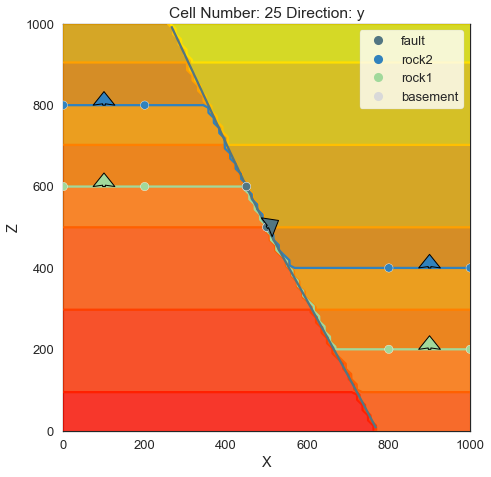

In [26]:
gp.plot_2d(geo_data, cell_number=25,
           direction='y', show_data=True, show_scalar=True, series_n=1)
plt.savefig('scalar.svg')

#### Defining important variables

In [2]:
# set standard derivation as same for all
point_std = 70

# surface points, vertical position
rock1_left_dist = norm(600, point_std)
rock1_right_dist = norm(200, point_std)
rock2_left_dist = norm(800, point_std)
rock2_right_dist = norm(400, point_std)

# fault points, lateral/ x-position:
fault_top_dist = norm(350, point_std)
fault_bottom_dist = norm(750, point_std)

In [12]:
# load posteriors dataframe
posteriors_df = pd.read_csv('accepted_500_hd.csv')

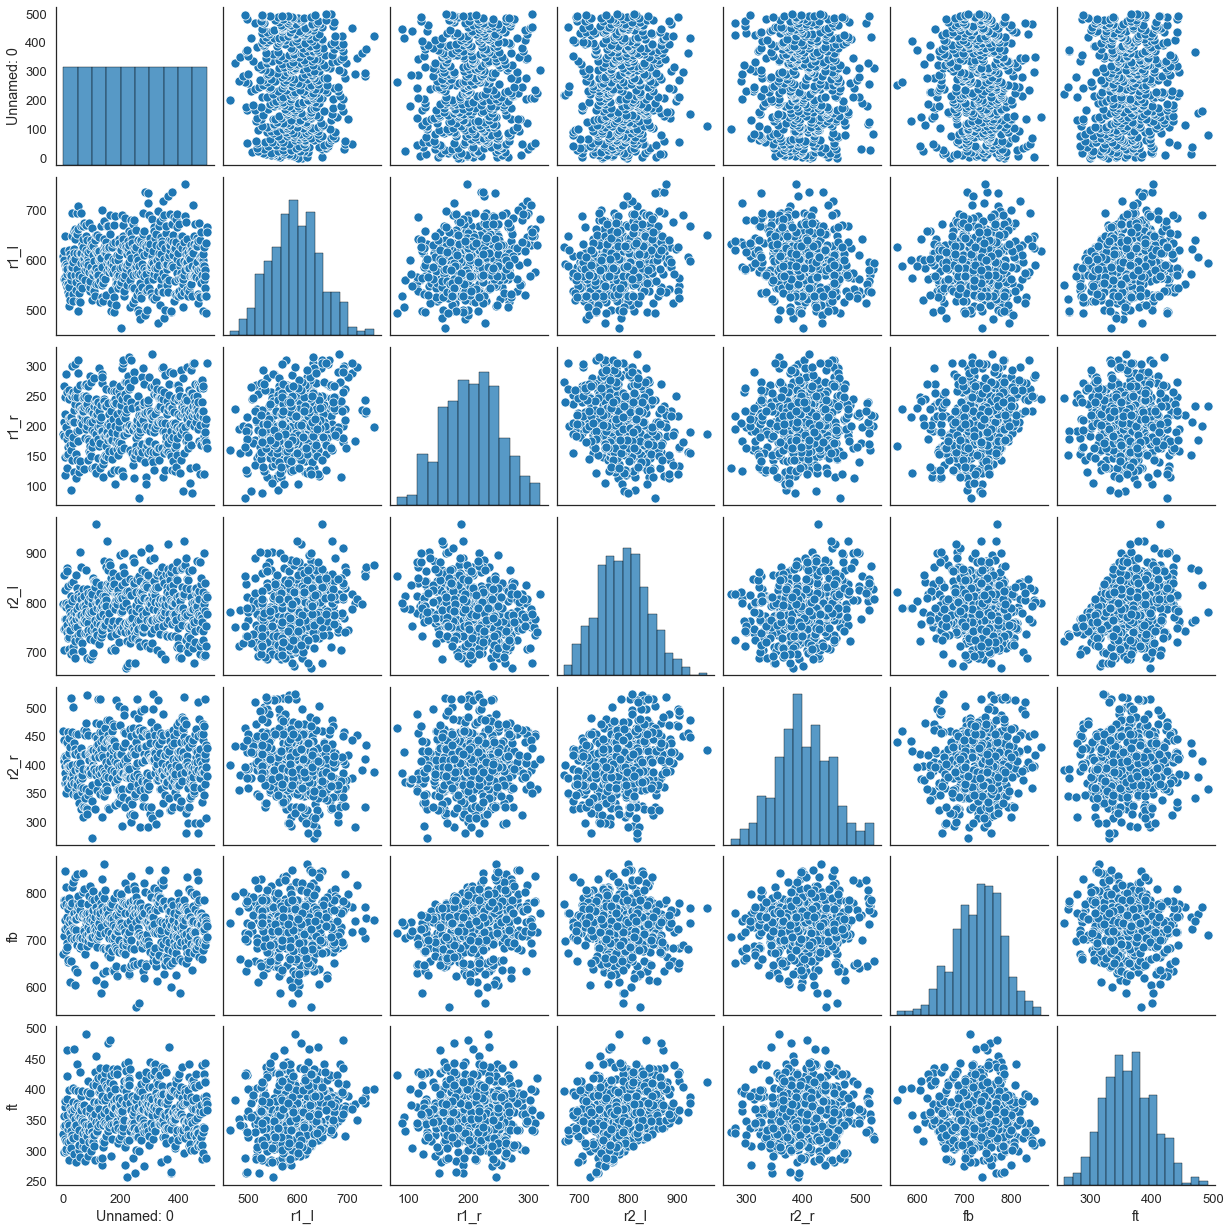

In [13]:
sns.pairplot(posteriors_df)

In [33]:
posteriors_df['r2_l'].mean()

788.8665928352503

### Parameter correlation visualization

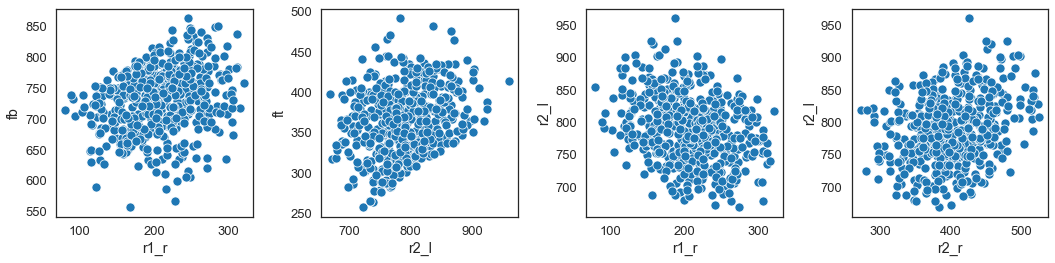

In [75]:
fig, ax = plt.subplots(1,4, figsize = (15,4))
sns.scatterplot(posteriors_df['r1_r'], posteriors_df['fb'], ax = ax[0])
sns.scatterplot(posteriors_df['r2_l'], posteriors_df['ft'], ax = ax[1])
sns.scatterplot(posteriors_df['r1_r'], posteriors_df['r2_l'], ax = ax[2])
sns.scatterplot(posteriors_df['r2_r'], posteriors_df['r2_l'], ax = ax[3])
fig.tight_layout()

In [7]:
### Also include the rejected samples in the graphs
import pandas as pd
rejected = pd.read_pickle(r'rejected_dict.pkl')

#re-sort dictionaries
rock1_left_acc = np.empty(len(rejected))
rock1_right_acc = np.empty(len(rejected))
rock2_left_acc = np.empty(len(rejected))
rock2_right_acc = np.empty(len(rejected))
fault_top_x_acc = np.empty(len(rejected))
fault_bottom_x_acc = np.empty(len(rejected))

for i,rej_dict in enumerate(rejected):
    rock1_left_acc[i] = rej_dict['rock1_left']
    rock1_right_acc[i] = rej_dict['rock1_right']
    rock2_left_acc[i] = rej_dict['rock2_left']
    rock2_right_acc[i] = rej_dict['rock2_right']
    fault_top_x_acc[i] = rej_dict['fault_top_x']
    fault_bottom_x_acc[i] = rej_dict['fault_bottom_x']

In [9]:
all_post = np.array([rock1_left_acc, rock1_right_acc, rock2_left_acc, rock2_right_acc, fault_bottom_x_acc, fault_top_x_acc])
rejected_df = pd.DataFrame(all_post.transpose(), columns = ['r1_l','r1_r','r2_l', 'r2_r', 'fb', 'ft'])
rejected_df.to_csv(r'rejected.csv')

In [14]:
r1_r_norm = np.random.normal(200,70,10000)
r2_r_norm = np.random.normal(400,70,10000)
r2_l_norm = np.random.normal(800,70,10000)
ft_norm = np.random.normal(350,70,10000)
fb_norm = np.random.normal(750,70,10000)

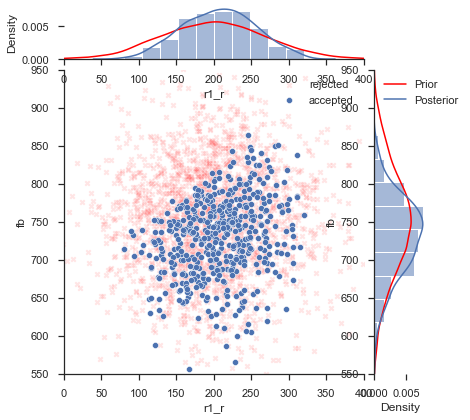

In [34]:
sns.set_theme(style = 'ticks')
df1 = posteriors_df.loc[:,['r1_r','fb']]

axs = sns.jointplot('r1_r', 'fb', data = posteriors_df, kind = 'kde', height=6,ratio=5)
axs.ax_joint.scatter('r1_r', 'fb', data = df1, alpha = 0.5)

axs.ax_marg_x.cla()
axs.ax_marg_y.cla()
axs.ax_joint.cla()
#
axs.ax_marg_x.set_xlim(0,400)
#axs.ax_marg_x.set(xticklabels = [])
#axs.ax_marg_x.tick_params(bottom = False)
axs.ax_marg_y.set_ylim(550,950)
#axs.ax_marg_y.set(yticklabels = [])
#axs.ax_marg_y.tick_params(left= False)

sns.scatterplot(rejected_df['r1_r'], rejected_df['fb'], ax=axs.ax_joint, alpha = 0.1, color = 'red', marker = 'X', label='rejected')
sns.scatterplot(posteriors_df['r1_r'], posteriors_df['fb'], ax=axs.ax_joint, alpha = 1, label='accepted')
#x axis
sns.histplot(posteriors_df['r1_r'], ax=axs.ax_marg_x, stat='density', bins=10, alpha = 0.5) 
sns.kdeplot(r1_r_norm, ax=axs.ax_marg_x,color = 'red', alpha = 0.5)
sns.kdeplot(posteriors_df['r1_r'], ax=axs.ax_marg_x)
#y axis
sns.histplot(y = posteriors_df['fb'], ax = axs.ax_marg_y, stat = 'density', bins = 10, alpha = 0.5)
sns.kdeplot(fb_norm, ax = axs.ax_marg_y, color = 'red', vertical = True, alpha = 0.5)
sns.kdeplot(posteriors_df['fb'], ax= axs.ax_marg_y, vertical = True)

plt.legend(["Prior" , "Posterior"])
plt.savefig('corr1.svg')

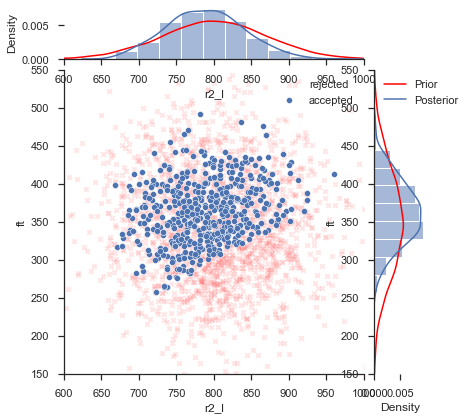

In [36]:
sns.set_theme(style = 'ticks')
df2= posteriors_df.loc[:,['r2_l', 'ft']]

axs = sns.jointplot('r2_l', 'ft', data = posteriors_df, kind = 'kde', height=6,ratio=5)
axs.ax_joint.scatter('r2_l', 'ft', data = df2, alpha = 0.5)

axs.ax_marg_x.cla()
axs.ax_marg_y.cla()
axs.ax_joint.cla()

axs.ax_marg_x.set_xlim(600,1000)
#axs.ax_marg_x.set(xticklabels = [])
#axs.ax_marg_x.tick_params(bottom = False)
axs.ax_marg_y.set_ylim(150,550)
#axs.ax_marg_y.set(yticklabels = [])
#axs.ax_marg_y.tick_params(left= False)

sns.scatterplot(rejected_df['r2_l'], rejected_df['ft'], ax = axs.ax_joint, alpha = 0.1, marker = 'X', label='rejected', color = 'red')
sns.scatterplot(posteriors_df['r2_l'], posteriors_df['ft'], ax=axs.ax_joint, alpha = 1, label='accepted')
#x axis
sns.histplot(posteriors_df['r2_l'], ax=axs.ax_marg_x, stat='density', bins=10, alpha = 0.5)
sns.kdeplot(r2_l_norm, ax=axs.ax_marg_x,color = 'red', alpha = 0.5)
sns.kdeplot(posteriors_df['r2_l'], ax=axs.ax_marg_x)
#y axis
sns.histplot(y = posteriors_df['ft'], ax = axs.ax_marg_y, stat = 'density', bins = 10, alpha = 0.5)
sns.kdeplot(ft_norm, ax = axs.ax_marg_y, color = 'red', vertical = True, alpha = 0.5)
sns.kdeplot(posteriors_df['ft'], ax= axs.ax_marg_y, vertical = True)

plt.legend(['Prior', 'Posterior'])
plt.savefig('corr2.svg')

<AxesSubplot:xlabel='Density', ylabel='r2_l'>

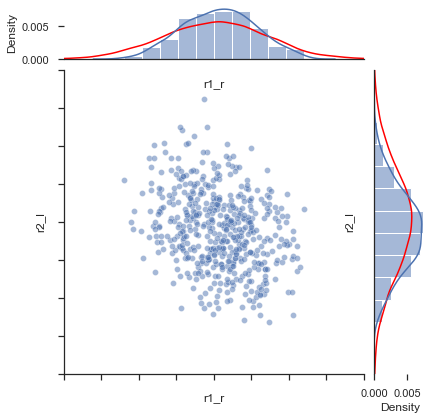

In [16]:
sns.set_theme(style = 'ticks')
df3= posteriors_df.loc[:,['r1_r', 'r2_l']]

axs = sns.jointplot('r1_r', 'r2_l', data = posteriors_df, kind = 'kde', height=6,ratio=5)
axs.ax_joint.scatter('r1_r', 'r2_l', data = df3, alpha = 0.5)

axs.ax_marg_x.cla()
axs.ax_marg_y.cla()
axs.ax_joint.cla()

axs.ax_marg_x.set_xlim(0,400)
axs.ax_marg_x.set(xticklabels = [])
axs.ax_marg_x.tick_params(bottom = False)
axs.ax_marg_y.set_ylim(600,1000)
axs.ax_marg_y.set(yticklabels = [])
axs.ax_marg_y.tick_params(left= False)

sns.scatterplot(posteriors_df['r1_r'], posteriors_df['r2_l'], ax=axs.ax_joint, alpha = 0.5)
#x axis
sns.histplot(posteriors_df['r1_r'], ax=axs.ax_marg_x, stat='density', bins=10, alpha = 0.5)
sns.kdeplot(r1_r_norm, ax=axs.ax_marg_x,color = 'red', alpha = 0.5)
sns.kdeplot(posteriors_df['r1_r'], ax=axs.ax_marg_x)
#y axis
sns.histplot(y = posteriors_df['r2_l'], ax = axs.ax_marg_y, stat = 'density', bins = 10, alpha = 0.5)
sns.kdeplot(r2_l_norm, ax = axs.ax_marg_y, color = 'red', vertical = True, alpha = 0.5)
sns.kdeplot(posteriors_df['r2_l'], ax= axs.ax_marg_y, vertical = True)

<AxesSubplot:xlabel='Density', ylabel='r2_l'>

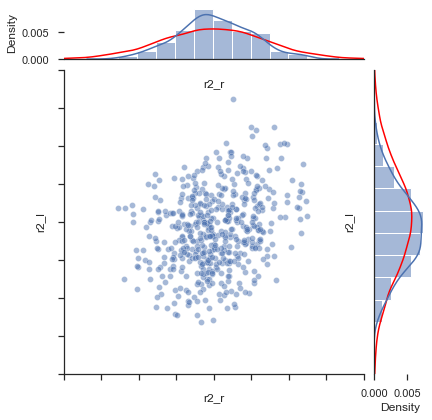

In [19]:
sns.set_theme(style = 'ticks')
df4= posteriors_df.loc[:,['r2_r', 'r2_l']]

axs = sns.jointplot('r2_r', 'r2_l', data = posteriors_df, kind = 'kde', height=6,ratio=5)
axs.ax_joint.scatter('r2_r', 'r2_l', data = df4, alpha = 0.5)

axs.ax_marg_x.cla()
axs.ax_marg_y.cla()
axs.ax_joint.cla()

axs.ax_marg_x.set_xlim(200,600)
axs.ax_marg_x.set(xticklabels = [])
axs.ax_marg_x.tick_params(bottom = False)
axs.ax_marg_y.set_ylim(600,1000)
axs.ax_marg_y.set(yticklabels = [])
axs.ax_marg_y.tick_params(left= False)

sns.scatterplot(posteriors_df['r2_r'], posteriors_df['r2_l'], ax=axs.ax_joint, alpha = 0.5)
#x axis
sns.histplot(posteriors_df['r2_r'], ax=axs.ax_marg_x, stat='density', bins=10, alpha = 0.5)
sns.kdeplot(r2_r_norm, ax=axs.ax_marg_x,color = 'red', alpha = 0.5)
sns.kdeplot(posteriors_df['r2_r'], ax=axs.ax_marg_x)
#y axis
sns.histplot(y = posteriors_df['r2_l'], ax = axs.ax_marg_y, stat = 'density', bins = 10, alpha = 0.5)
sns.kdeplot(r2_l_norm, ax = axs.ax_marg_y, color = 'red', vertical = True, alpha = 0.5)
sns.kdeplot(posteriors_df['r2_l'], ax= axs.ax_marg_y, vertical = True)

### Uncertainty figures

#### Prior entropy (lith blocks)

In [2]:
n_iterations = 500

In [3]:
lith_blocks_list_pr = os.listdir('lith_blocks_pr')

#join all lith_blocks into a single array
lith_blocks_pr = np.array([])
for block in lith_blocks_list_pr:
    lith_blocks_pr = np.append(lith_blocks_pr, np.load('lith_blocks_pr\\' + block))

In [4]:
lith_blocks_orient_pr = lith_blocks_pr.reshape(n_iterations, -1)
prob_block_pr = compute_prob(lith_blocks_orient_pr)
entropy_block_pr = calculate_ie_masked(prob_block_pr)

C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:8: UserWarning: This function is Deprecated, please use the probability function instead
  warnings.warn("This function is Deprecated, please use the probability function instead")
C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:23: UserWarning: This function is Deprecated, please use the information_entropy function instead
  warnings.warn("This function is Deprecated, please use the information_entropy function instead")


In [5]:
np.save(r'entropy_blocks/entropy_block_pr', entropy_block_pr)

In [5]:
print(entropy_block_pr.reshape(80,80,80).max()) #of the whole model
print(entropy_block_pr.reshape(80,80,80).min()) #of the whole model
print(entropy_block_pr.reshape(80,80,80).mean()) #of the whole model

1.5654872786429779
0.0
0.42495960512817466


In [6]:
entropy_whole_pr = entropy_block_pr.reshape(80,80,80)
entropy_whole_pr[entropy_whole_pr == 0] = ['nan']
print(np.nanmean(entropy_whole_pr)) #of the whole model

0.5237271878415031


#### Prior entropy (fault blocks)

In [7]:
fault_blocks_list_pr = os.listdir('fault_blocks_pr')

#join all lith_blocks into a single array
fault_blocks_pr = np.array([])
for fault in fault_blocks_list_pr:
    fault_blocks_pr = np.append(fault_blocks_pr, np.load('fault_blocks_pr\\' + fault)[0, 0:512000])

In [10]:
fault_blocks_orient_pr = fault_blocks_pr.reshape(n_iterations, -1)
prob_fblock_pr = compute_prob(fault_blocks_orient_pr)
entropy_fblock_pr = calculate_ie_masked(prob_fblock_pr)

C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:8: UserWarning: This function is Deprecated, please use the probability function instead
  warnings.warn("This function is Deprecated, please use the probability function instead")
C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:23: UserWarning: This function is Deprecated, please use the information_entropy function instead
  warnings.warn("This function is Deprecated, please use the information_entropy function instead")


In [11]:
np.save(r'entropy_blocks/entropy_fblock_pr', entropy_fblock_pr)

In [6]:
print(entropy_fblock_pr.reshape(80,80,80).max()) #of the whole model
print(entropy_fblock_pr.reshape(80,80,80).min()) #of the whole model
print(entropy_fblock_pr.reshape(80,80,80).mean()) #of the whole model

1.0
0.0
0.15674068411599587


In [8]:
#mean without 0s
entropy_fwhole_pr = entropy_fblock_pr.reshape(80,80,80)
entropy_fwhole_pr[entropy_fwhole_pr == 0] = ['nan']
print(np.nanmean(entropy_fwhole_pr)) #of the whole model

0.4148636800423381


#### Posterior entropy -lith blocks

In [12]:
lith_blocks_list = os.listdir('lith_blocks')

#join all lith_blocks into a single array
lith_blocks = np.array([])
for block in lith_blocks_list:
    lith_blocks = np.append(lith_blocks, np.load('lith_blocks\\' + block))

In [13]:
lith_blocks_orient = lith_blocks.reshape(n_iterations, -1)
prob_block = compute_prob(lith_blocks_orient)
entropy_block = calculate_ie_masked(prob_block)

In [14]:
np.save(r'entropy_blocks/entropy_block', entropy_block)

#### Statistics

In [25]:
print(entropy_block.reshape(80,80,80).max()) #of the whole model
print(entropy_block.reshape(80,80,80).min()) #of the whole model
print(entropy_block.reshape(80,80,80).mean()) #of the whole model

1.582298321781936
0.0
0.2517913025952746


In [26]:
#mean without 0s
entropy_whole = entropy_block.reshape(80,80,80)
entropy_whole[entropy_whole == 0] = ['nan']
print(np.nanmean(entropy_whole)) #of the whole model

0.5603363610745404


#### Posterior entropy (fault blocks)

In [3]:
fault_blocks_list = os.listdir('fault_blocks')

#join all lith_blocks into a single array
fault_blocks = np.array([])
for fault in fault_blocks_list:
    fault_blocks = np.append(fault_blocks, np.load('fault_blocks\\' + fault)[0, 0:512000])

In [4]:
fault_blocks_orient = fault_blocks.reshape(n_iterations, -1)
prob_fblock = compute_prob(fault_blocks_orient)
entropy_fblock = calculate_ie_masked(prob_fblock)

C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:8: UserWarning: This function is Deprecated, please use the probability function instead
  warnings.warn("This function is Deprecated, please use the probability function instead")
C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:23: UserWarning: This function is Deprecated, please use the information_entropy function instead
  warnings.warn("This function is Deprecated, please use the information_entropy function instead")


In [5]:
np.save(r'entropy_blocks/entropy_fblock', entropy_fblock)

In [11]:
print(entropy_fblock.reshape(80,80,80).max()) #of the whole model
print(entropy_fblock.reshape(80,80,80).min()) #of the whole model
print(entropy_fblock.reshape(80,80,80).mean()) #of the whole model

1.0
0.0
0.10559741790834529


In [12]:
#mean without 0s
entropy_fwhole = entropy_fblock.reshape(80,80,80)
entropy_fwhole[entropy_fwhole == 0] = ['nan']
print(np.nanmean(entropy_fwhole)) #of the whole model

0.4575649794268178


#### Plotting the uncertainty

#### 2D

In [39]:
entropy_block_pr = np.load('entropy_blocks/entropy_block_pr.npy')
entropy_fblock_pr = np.load('entropy_blocks/entropy_fblock_pr.npy')
entropy_block_ps = np.load('entropy_blocks/entropy_block.npy')
entropy_fblock_ps = np.load('entropy_blocks/entropy_fblock.npy')

In [40]:
entropy_diff_lith = entropy_block_pr -entropy_block
entropy_diff_fault = entropy_fblock_pr - entropy_fblock 

ValueError: operands could not be broadcast together with shapes (512000,) (320000,) 

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

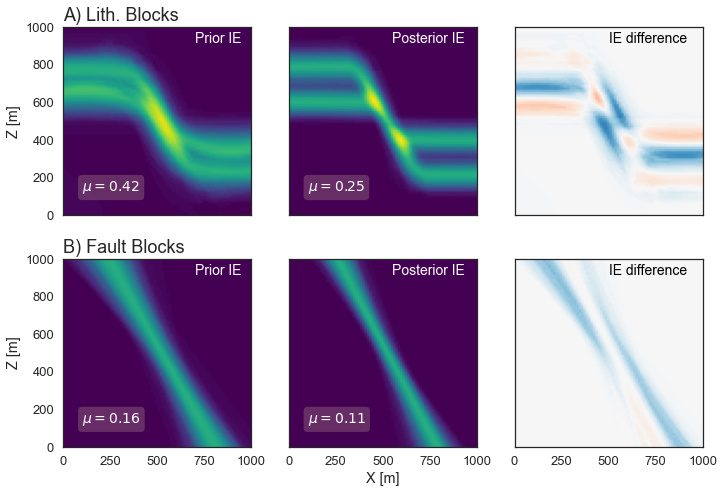

In [125]:
cell = 40
fig, ax= plt.subplots(2,3, sharey = True, sharex = True)


im1 = ax[0,0].imshow(entropy_block_pr.reshape(80,80,80)[:,cell,:].T, cmap = 'viridis', origin = 'lower',
              extent = [0,1000,0,1000], vmax=1.6)
im2 = ax[0,1].imshow(entropy_block.reshape(80,80,80)[:,cell,:].T, cmap = 'viridis', origin = 'lower',
              extent = [0,1000,0,1000], vmax=1.6)
im3 = ax[0,2].imshow(entropy_diff_lith.reshape(80,80,80)[:,cell,:].T, cmap = 'RdBu', origin = 'lower',
              extent = [0,1000,0,1000], clim = [-1.15,1.15])
im4 = ax[1,0].imshow(entropy_fblock_pr.reshape(80,80,80)[:,cell,:].T, cmap = 'viridis', origin = 'lower',
              extent = [0,1000,0,1000], vmax=1.6)
im5 = ax[1,1].imshow(entropy_fblock.reshape(80,80,80)[:,cell,:].T, cmap = 'viridis', origin = 'lower',
              extent = [0,1000,0,1000], vmax=1.6)
im6 = ax[1,2].imshow(entropy_diff_fault.reshape(80,80,80)[:,cell,:].T, cmap = 'RdBu', origin = 'lower',
              extent = [0,1000,0,1000], clim = [-1.15, 1.15])

#Axes labels
ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('Z [m]')
ax[1,1].set_xlabel('X [m]')

ax[0,0].set_title('A) Lith. Blocks', loc = 'left', fontsize = 18)
ax[1,0].set_title('B) Fault Blocks', loc = 'left', fontsize = 18)

#Textboxes
ax[0,0].text(0.7,0.9, 'Prior IE', fontsize = 14, verticalalignment = 'bottom', color = 'white',transform = ax[0,0].transAxes)
ax[0,1].text(0.55,0.9, 'Posterior IE', fontsize = 14, verticalalignment = 'bottom', color = 'white',transform = ax[0,1].transAxes)
ax[0,2].text(0.5,0.9, 'IE difference', fontsize = 14, verticalalignment = 'bottom', color = 'black',transform = ax[0,2].transAxes)

ax[1,0].text(0.7,0.9, 'Prior IE', fontsize = 14, verticalalignment = 'bottom', color = 'white',transform = ax[1,0].transAxes)
ax[1,1].text(0.55,0.9, 'Posterior IE', fontsize = 14, verticalalignment = 'bottom', color = 'white',transform = ax[1,1].transAxes)
ax[1,2].text(0.5,0.9, 'IE difference', fontsize = 14, verticalalignment = 'bottom', color = 'black',transform = ax[1,2].transAxes)


props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.2)
ax[0,0].text(0.1,0.1, '$\mu=0.42$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[0,0].transAxes, bbox = props)
ax[0,1].text(0.1,0.1, '$\mu=0.25$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[0,1].transAxes, bbox = props)
ax[1,0].text(0.1,0.1, '$\mu=0.16$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[1,0].transAxes, bbox = props)
ax[1,1].text(0.1,0.1, '$\mu=0.11$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[1,1].transAxes, bbox = props)

#colorbar

fig.tight_layout()

plt.savefig('entropy_comparison.svg')

In [107]:
# Plot colorbars separately cause I'm stupid

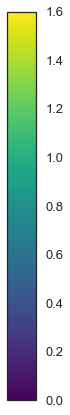

In [126]:
import pylab as pl

a = np.array([[0,1.6]])
pl.figure(figsize=(0.5,9))
img = pl.imshow(a, cmap="viridis")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="vertical", cax=cax)
pl.savefig("colorbar1.png")

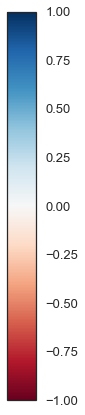

In [127]:
a = np.array([[-1,1]])
pl.figure(figsize=(0.5,9))
img = pl.imshow(a, cmap="RdBu")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="vertical", cax=cax)
pl.savefig("colorbar2.png")

#### 3D

In [32]:
entropy_block = entropy_block.reshape(80,80,80)
entropy_block_mapped = resize(entropy_block.reshape(80,80,80),(80,80,80))

In [46]:
def plot_entropy_3d(array):
    sargs = dict(
        n_labels= 4,
        fmt="%.2f",
        color='black'
    )
        
    p = pv.Plotter(notebook = False)
    p.camera_position =[(225.42616094676856, 399.12340631668496, 257.3912472495674), 
                        (-74.48617945870785, 148.24735445450216, -18.0350197347693), 
                        (-0.4070592293592159, -0.409653310787582, 0.8163865192139408)]
    x = np.arange(0, array.shape[1], 1)
    y = np.arange(0, array.shape[0], 1)
    z = np.arange(0, array.shape[2], 1)
    x, y, z = np.meshgrid(-x, y, z)


    grid = pv.StructuredGrid(x, y, z)
    grid["Entropy"] = array.ravel(order="F")
    p.add_mesh(grid, scalars=grid["Entropy"], cmap='viridis', show_scalar_bar = True, scalar_bar_args=sargs, clim=[0,2.1], stitle='Information Entropy')
 #   p.add_text(formations[i], position='upper_edge', font_size=12, color='black', shadow = True)

    p.set_background('white')
    p.show_grid(color='black')
    p.show()

In [36]:
plot_entropy_3d(entropy_block_mapped)

C:\ProgramData\Anaconda3\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


# Entropy plots case study

### Prior entropy

#### Lith blocks

In [2]:
lith_blocks_list = os.listdir(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\lith_blocks\100')

#join all lith_blocks into a single array
lith_blocks = np.array([])
for block in lith_blocks_list:
    lith_blocks = np.append(lith_blocks, np.load(r'C:\\Users\\Sofia\\Documents\\Sofia\\gempy_models\\final_models\\lith_blocks\\100\\' + block))

In [5]:
n_iterations = 100

In [4]:
lith_blocks_orient = lith_blocks.reshape(n_iterations, -1)
prob_block = compute_prob(lith_blocks_orient)
entropy_block = calculate_ie_masked(prob_block)

C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:8: UserWarning: This function is Deprecated, please use the probability function instead
  warnings.warn("This function is Deprecated, please use the probability function instead")
C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:23: UserWarning: This function is Deprecated, please use the information_entropy function instead
  warnings.warn("This function is Deprecated, please use the information_entropy function instead")


In [6]:
np.save(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_block_pr.npy', entropy_block)

In [8]:
print(entropy_block.reshape(80,80,50).max()) #of the whole model
print(entropy_block.reshape(80,80,50).min()) #of the whole model
print(entropy_block.reshape(80,80,50).mean()) #of the whole model

2.318678980992639
0.0
0.3390573933210732


In [10]:
#mean without 0s
entropy_whole = entropy_block.reshape(80,80,50)
entropy_whole[entropy_whole == 0] = ['nan']
print(np.nanmean(entropy_whole)) #of the whole model

0.698776741414857


#### fault_blocks

In [2]:
fault_blocks_list = os.listdir(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\fault_blocks\100')

#join all lith_blocks into a single array
fault_blocks = np.array([])
for fault in fault_blocks_list:
    fault_blocks = np.append(fault_blocks, np.load(r'C:\\Users\\Sofia\\Documents\\Sofia\\gempy_models\\final_models\\fault_blocks\\100\\' + fault)[0, 0:320000])

In [6]:
fault_blocks_orient = fault_blocks.reshape(n_iterations, -1)
prob_fblock = compute_prob(fault_blocks_orient)
entropy_fblock = calculate_ie_masked(prob_fblock)

C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:8: UserWarning: This function is Deprecated, please use the probability function instead
  warnings.warn("This function is Deprecated, please use the probability function instead")
C:\ProgramData\Anaconda3\lib\site-packages\gempy\bayesian\fields.py:23: UserWarning: This function is Deprecated, please use the information_entropy function instead
  warnings.warn("This function is Deprecated, please use the information_entropy function instead")


In [9]:
np.save(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_fblock_pr.npy', entropy_fblock)

In [14]:
print(entropy_fblock.reshape(80,80,50).max()) #of the whole model
print(entropy_fblock.reshape(80,80,50).min()) #of the whole model
print(entropy_fblock.reshape(80,80,50).mean()) #of the whole model

2.120717181863926
0.0
0.13770868232630112


In [16]:
#mean without 0s
entropy_fwhole = entropy_fblock.reshape(80,80,50)
entropy_fwhole[entropy_fwhole == 0] = ['nan']
print(np.nanmean(entropy_fwhole)) #of the whole model

0.7425274798122291


### Prior 2d Plots

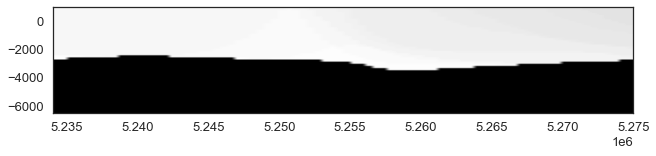

In [15]:
plt.imshow(np.fliplr(fault_blocks_orient[].reshape(80,80,50)[20,:,:].T).astype(int), cmap = 'gray', origin = 'lower',
              extent = [5234000,5275000,-6500,1000])

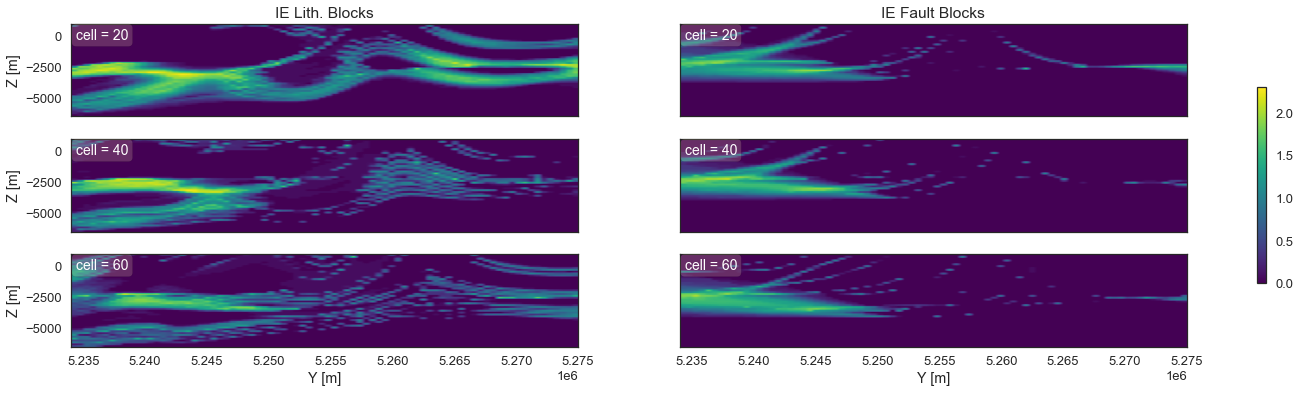

In [26]:
fig, ax= plt.subplots(3,2,sharex = True,sharey = True, figsize = (25,6))

im1 = ax[0,0].imshow(entropy_block_pr.reshape(80,80,50)[20,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)
im2 = ax[1,0].imshow(entropy_block_pr.reshape(80,80,50)[40,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)
im3 = ax[2,0].imshow(entropy_block_pr.reshape(80,80,50)[60,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)

im4 = ax[0,1].imshow(entropy_fblock_pr.reshape(80,80,50)[20,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)
im5 = ax[1,1].imshow(entropy_fblock_pr.reshape(80,80,50)[40,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)
im6 = ax[2,1].imshow(entropy_fblock_pr.reshape(80,80,50)[60,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)

ax[2,0].set_xlabel('Y [m]')
ax[2,1].set_xlabel('Y [m]')
ax[0,0].set_ylabel('Z [m]')
ax[1,0].set_ylabel('Z [m]')
ax[2,0].set_ylabel('Z [m]')

ax[0,0].set_title('IE Lith. Blocks')
ax[0,1].set_title('IE Fault Blocks')

props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.2)

ax[0,0].text(0.01,0.8, 'cell = 20',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[0,0].transAxes, bbox = props)
ax[1,0].text(0.01,0.8, 'cell = 40',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[1,0].transAxes, bbox = props)
ax[2,0].text(0.01,0.8, 'cell = 60',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[2,0].transAxes, bbox = props)
ax[0,1].text(0.01,0.8, 'cell = 20',fontsize = 14, verticalalignment = 'bottom', color = 'white',
            transform = ax[0,1].transAxes, bbox = props)
ax[1,1].text(0.01,0.8, 'cell = 40',fontsize = 14, verticalalignment = 'bottom', color = 'white',
            transform = ax[1,1].transAxes, bbox = props)
ax[2,1].text(0.01,0.8, 'cell = 60',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[2,1].transAxes, bbox = props)

fig.colorbar(im1, ax = ax[:], shrink = 0.6, location = 'right', orientation = 'vertical')

plt.savefig('entropy_prior_casestudy.svg')

### Prior 3d plots

In [47]:
entropy_fblock_pr = entropy_fblock_pr.reshape(80,80,50)
entropy_fblock_mapped_pr = resize(entropy_fblock_pr.reshape(80,80,50),(80,160,25))

In [ ]:
plot_entropy_3d(entropy_fblock_mapped_pr)

### Posterior entropy

#### Lith blocks

In [11]:
lith_blocks_list_ps = os.listdir(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\lith_blocks_topo')

#join all lith_blocks into a single array
lith_blocks_ps = np.array([])
for block in lith_blocks_list_ps:
    lith_blocks_ps = np.append(lith_blocks_ps, np.load(r'C:\\Users\\Sofia\\Documents\\Sofia\\gempy_models\\final_models\\lith_blocks_topo\\' + block))

In [12]:
n_iterations = 100

In [13]:
lith_blocks_orient_ps = lith_blocks_ps.reshape(n_iterations, -1)
prob_block_ps = compute_prob(lith_blocks_orient_ps)
entropy_block_ps = calculate_ie_masked(prob_block_ps)

In [14]:
np.save(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_block_ps.npy', entropy_block_ps)

In [6]:
print(entropy_block_ps.reshape(80,80,50).max()) #of the whole model
print(entropy_block_ps.reshape(80,80,50).min()) #of the whole model
print(entropy_block_ps.reshape(80,80,50).mean()) #of the whole model

2.2924958900123715
0.0
0.2838958912657263


In [7]:
#mean without 0s
entropy_whole_ps = entropy_block_ps.reshape(80,80,50)
entropy_whole_ps[entropy_whole_ps == 0] = ['nan']
print(np.nanmean(entropy_whole_ps)) #of the whole model

0.7285745178483805


#### Fault blocks

In [15]:
fault_blocks_list_ps = os.listdir(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\fault_blocks_topo')

#join all lith_blocks into a single array
fault_blocks_ps = np.array([])
for fault in fault_blocks_list_ps:
    fault_blocks_ps = np.append(fault_blocks_ps, np.load(r'C:\\Users\\Sofia\\Documents\\Sofia\\gempy_models\\final_models\\fault_blocks_topo\\' + fault)[0, 0:320000])

In [16]:
fault_blocks_orient_ps = fault_blocks_ps.reshape(n_iterations, -1)
prob_fblock_ps = compute_prob(fault_blocks_orient_ps)
entropy_fblock_ps = calculate_ie_masked(prob_fblock_ps)

In [17]:
np.save(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_fblock_ps.npy', entropy_fblock_ps)

In [11]:
print(entropy_fblock_ps.reshape(80,80,50).max()) #of the whole model
print(entropy_fblock_ps.reshape(80,80,50).min()) #of the whole model
print(entropy_fblock_ps.reshape(80,80,50).mean()) #of the whole model

2.05333118961139
0.0
0.12755230743792062


In [12]:
#mean without 0s
entropy_fwhole_ps = entropy_fblock_ps.reshape(80,80,50)
entropy_fwhole_ps[entropy_fwhole_ps == 0] = ['nan']
print(np.nanmean(entropy_fwhole_ps)) #of the whole model

0.7635290953671031


#### 2d Plots

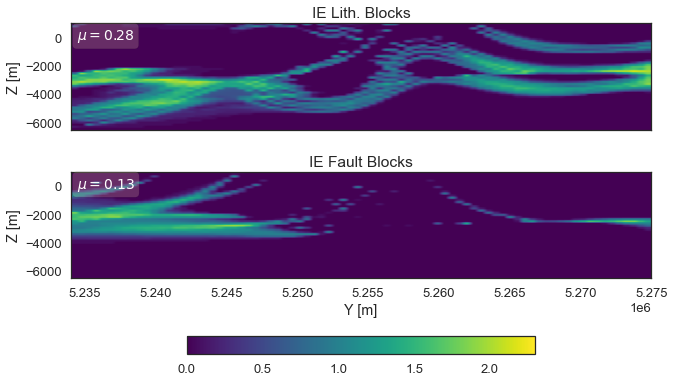

In [21]:
cell = 20
fig, ax= plt.subplots(2,1,sharex = True)

im1 = ax[0].imshow(entropy_block_ps.reshape(80,80,50)[cell,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)
im2 = ax[1].imshow(entropy_fblock_ps.reshape(80,80,50)[cell,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)

ax[1].set_xlabel('Y [m]')
ax[0].set_ylabel('Z [m]')
ax[1].set_ylabel('Z [m]')

ax[0].set_title('IE Lith. Blocks')
ax[1].set_title('IE Fault Blocks')
props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.2)

ax[0].text(0.01,0.8, '$\mu=0.28$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[0].transAxes, bbox = props)
ax[1].text(0.01,0.8, '$\mu=0.13$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[1].transAxes, bbox = props)

fig.colorbar(im1, ax = ax[:], shrink = 0.6, location = 'bottom')

#### Comparison plot

In [11]:
entropy_block = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_block.npy')

#### Lith blocks

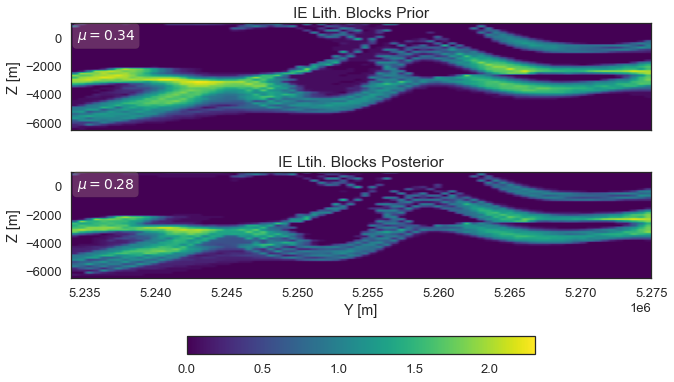

In [20]:
cell = 20
fig, ax= plt.subplots(2,1,sharex = True)

im1 = ax[0].imshow(entropy_block_pr.reshape(80,80,50)[cell,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)
im2 = ax[1].imshow(entropy_block_ps.reshape(80,80,50)[cell,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.3)

ax[1].set_xlabel('Y [m]')
ax[0].set_ylabel('Z [m]')
ax[1].set_ylabel('Z [m]')

ax[0].set_title('IE Lith. Blocks Prior')
ax[1].set_title('IE Ltih. Blocks Posterior')
props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.2)

ax[0].text(0.01,0.8, '$\mu=0.34$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[0].transAxes, bbox = props)
ax[1].text(0.01,0.8, '$\mu=0.28$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[1].transAxes, bbox = props)

fig.colorbar(im1, ax = ax[:], shrink = 0.6, location = 'bottom')

In [19]:
entropy_fblock = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_fblock.npy')

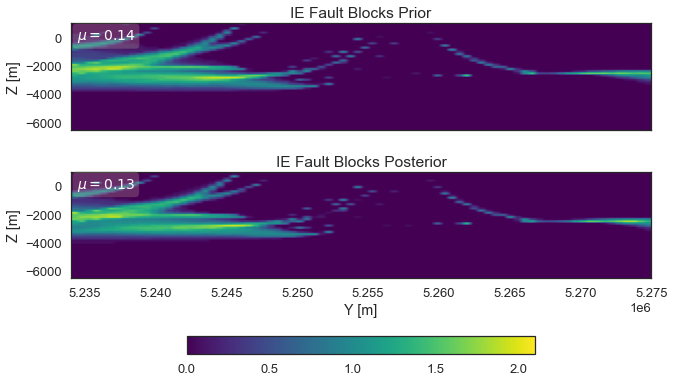

In [19]:
cell = 20
fig, ax= plt.subplots(2,1,sharex = True)

im1 = ax[0].imshow(entropy_fblock_pr.reshape(80,80,50)[cell,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.1)
im2 = ax[1].imshow(entropy_fblock_ps.reshape(80,80,50)[cell,:,:].T, cmap = 'viridis', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], vmax=2.1)

ax[1].set_xlabel('Y [m]')
ax[0].set_ylabel('Z [m]')
ax[1].set_ylabel('Z [m]')

ax[0].set_title('IE Fault Blocks Prior')
ax[1].set_title('IE Fault Blocks Posterior')
props = dict(boxstyle = 'round', facecolor = 'wheat', alpha = 0.2)

ax[0].text(0.01,0.8, '$\mu=0.14$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[0].transAxes, bbox = props)
ax[1].text(0.01,0.8, '$\mu=0.13$',fontsize = 14, verticalalignment = 'bottom', color = 'white',
             transform = ax[1].transAxes, bbox = props)

fig.colorbar(im1, ax = ax[:], shrink = 0.6, location = 'bottom')

### Entropy difference plot

In [43]:
entropy_block_pr = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_block_pr.npy')
entropy_block_ps = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_block_ps.npy')
entropy_fblock_pr = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_fblock_pr.npy')
entropy_fblock_ps = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_fblock_ps.npy')

In [3]:
entropy_diff_lith_cs = entropy_block_pr - entropy_block_ps
entropy_diff_fault_cs = entropy_fblock_pr - entropy_fblock_ps

In [5]:
entropy_diff_fault_cs.min()

-0.7957648872398648

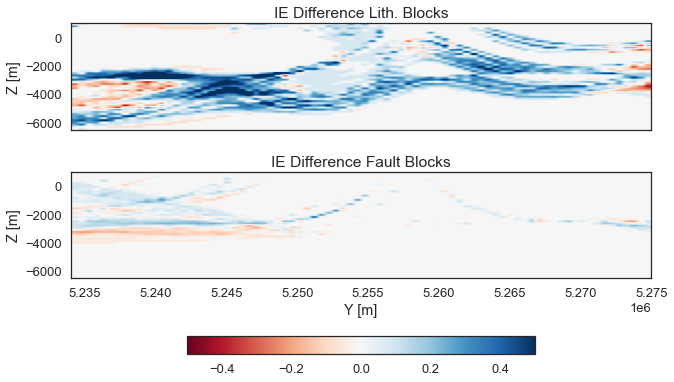

In [17]:
cell = 20
fig, ax= plt.subplots(2,1,sharex = True)

im1 = ax[0].imshow(entropy_diff_lith_cs.reshape(80,80,50)[cell,:,:].T, cmap = 'RdBu', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], clim = [-0.5, 0.5])
im2 = ax[1].imshow(entropy_diff_fault_cs.reshape(80,80,50)[cell,:,:].T, cmap = 'RdBu', origin = 'lower',
              extent = [5234000,5275000,-6500,1000], clim = [-0.8, 0.8])

ax[1].set_xlabel('Y [m]')
ax[0].set_ylabel('Z [m]')
ax[1].set_ylabel('Z [m]')

ax[0].set_title('IE Difference Lith. Blocks')
ax[1].set_title('IE Difference Fault Blocks')

#cbar_ax = fig.add_axes([0.99, 0.15, 0.03, 0.7])
#fig.colorbar(im1, cax=cbar_ax)

fig.colorbar(im1, ax = ax[:], shrink = 0.6, location = 'bottom')

### Trying out different 3D entropy plots

In [2]:
entropy_block_pr = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_block_pr.npy')
entropy_fblock_pr = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_fblock_pr.npy')

In [31]:
#Load, reshape and resize
entropy_block_pr = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_block_pr.npy')
entropy_fblock_pr = np.load(r'C:\Users\Sofia\Documents\Sofia\gempy_models\final_models\entropy_blocks\entropy_fblock_pr.npy')

entropy_block_pr = entropy_block_pr.reshape(80,80,50)
entropy_fblock_pr = entropy_fblock_pr.reshape(80,80,50)

entropy_block_mapped = resize(entropy_block_pr.reshape(80,80,50),(80,125,32))
entropy_fblock_mapped = resize(entropy_fblock_pr.reshape(80,80,50),(80,125,32))

In [59]:
def plot_entropy_3d(array):
    sargs = dict(
        n_labels= 4,
        fmt="%.2f",
        color='black'
    )
        
    p = pv.Plotter(notebook = False)
    p.camera_position =[(225.42616094676856, 399.12340631668496, 257.3912472495674), 
                        (-74.48617945870785, 148.24735445450216, -18.0350197347693), 
                        (-0.4070592293592159, -0.409653310787582, 0.8163865192139408)]
    x = np.arange(0, array.shape[1], 1)
    y = np.arange(0, array.shape[0], 1)
    z = np.arange(0, array.shape[2], 1)
    x, y, z = np.meshgrid(-x, y, z)

    grid = pv.StructuredGrid(x, y, z)
    grid["Entropy"] = array.ravel(order="F")
    thresh = grid.threshold((0.2,2), 'Entropy')
    p.add_mesh(thresh, scalars=thresh["Entropy"], cmap='viridis', show_scalar_bar = True, scalar_bar_args=sargs, clim=[0,2.1], stitle='Information Entropy')
 #   p.add_text(formations[i], position='upper_edge', font_size=12, color='black', shadow = True)

    p.set_background('white')
    p.show_grid(color='black')
    p.show()

In [ ]:
plot_entropy_3d(entropy_fblock_mapped)